## The Problem Description:

In this hands-on project, the goal is to build a Face Mask Segmentation model which includes building a face detector to locate the position of a face in an image.


## Data Description:

### ***WIDER Face Dataset*** 

WIDER FACE dataset is a Face Mask Segmentation benchmark dataset, of which images are selected from the publicly available WIDER dataset. This data have 32,203 images and 393,703 faces are labeled with a high degree of variability in scale, pose and occlusion as depicted in the sample images.
In this project, we are using 409 images and around 1000 faces for ease of computation.
We will be using transfer learning on an already trained model to build our segmenter. We will perform transfer learning on the MobileNet model which is already trained to perform image segmentation. We will need to train the last 6-7 layers and freeze the remaining layers to train the model for face mask segmentation. To be able to train the MobileNet model for face mask segmentation, we will be using the WIDER FACE dataset for various images with a single face and multiple faces. The output of the model is the face mask segmented data which masks the face in an image. We learn to build a face mask segmentation model using Keras supported by Tensorflow.

**Link to the dataset:** 
https://drive.google.com/file/d/1L2-WXzguhUsCArrFUc8EEkXcj33pahoS/view?usp=sharing


**Acknowledgement for the datasets.** 
Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading Digits in Natural Images with Unsupervised Feature Learning NIPS Workshop on Deep Learning and Unsupervised Feature Learning 2011. PDF http://ufldl.stanford.edu/housenumbers as the URL for this site when necessary


## Objective:

In this problem, we use "Transfer Learning" of an Image Segmentation model to detect any object according to the problem in hand.
Here, we are particularly interested in segmenting faces in a given image:
Steps and tasks
1. Load the dataset given in form .npy format.
2. Create Features(images) and labels(mask) using that data.
3. Load the pre-trained model and weights.
4. Create a model using the above model.
5. Define the Dice Coefficient and Loss function.
6. Compile and fit the model.
7. Evaluate the model.













In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive') # mounting for storage

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Import all the required libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,multilabel_confusion_matrix,confusion_matrix,accuracy_score

import h5py
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation,Dense,BatchNormalization,Dropout,LeakyReLU
from tensorflow.keras import regularizers,optimizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load the data

In [4]:
# To load train set, validation set and test set

h5f = h5py.File('/content/gdrive/My Drive/AIML_Colab/NN Assignment 1/SVHN_single_grey1.h5','r')

X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]

X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

h5f.close()

# saving a copy
Xtrain = X_train
ytrain = y_train
Xtest = X_test
ytest = y_test
Xval = X_val
yval = y_val

In [5]:
print('Dimensions of Train Set are {}'.format(X_train.shape))
print('Dimensions of Validation Set are {}'.format(X_val.shape))
print('Dimensions of Test Set are {}'.format(X_test.shape))

Dimensions of Train Set are (42000, 32, 32)
Dimensions of Validation Set are (60000, 32, 32)
Dimensions of Test Set are (18000, 32, 32)


In [6]:
# Checking the unique values of the labels
print(np.unique(y_train))
print(np.unique(y_val))
print(np.unique(y_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


### To check the True labels and Predicted labels after model evaluation

In [7]:
# To check training and predicted data before and after model prediction
def plot_images(img,labels,nrows,ncols,pred_labels=None):
    fig = plt.figure(figsize=(20,6))
    axes = fig.subplots(nrows,ncols)
    for i, ax in enumerate(axes.flat):
        ax.imshow(img[i])
        ax.set_xticks([])
        ax.set_yticks([])
        
        if pred_labels is None:
            ax.set_title(f'True: {labels[i]}')
        else:
            ax.set_title(f'True: {labels[i]}, Pred: {np.argmax(pred_labels[i], axis = -1)}' )

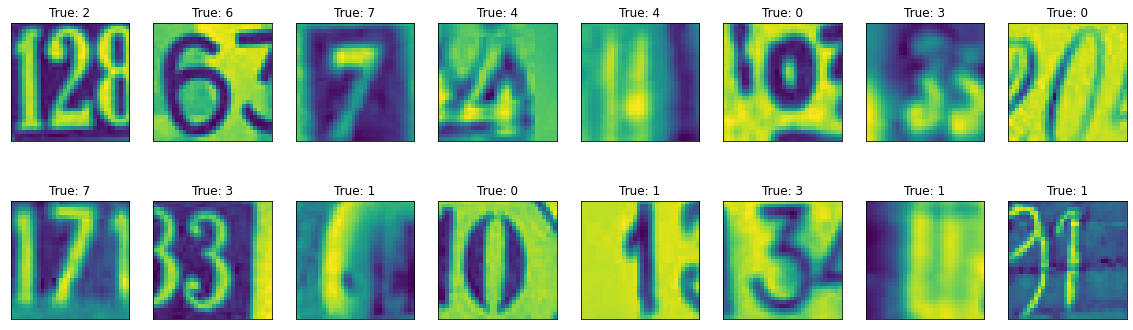

In [8]:
# Checking on a few training images
plot_images(X_train, y_train, 2, 8)

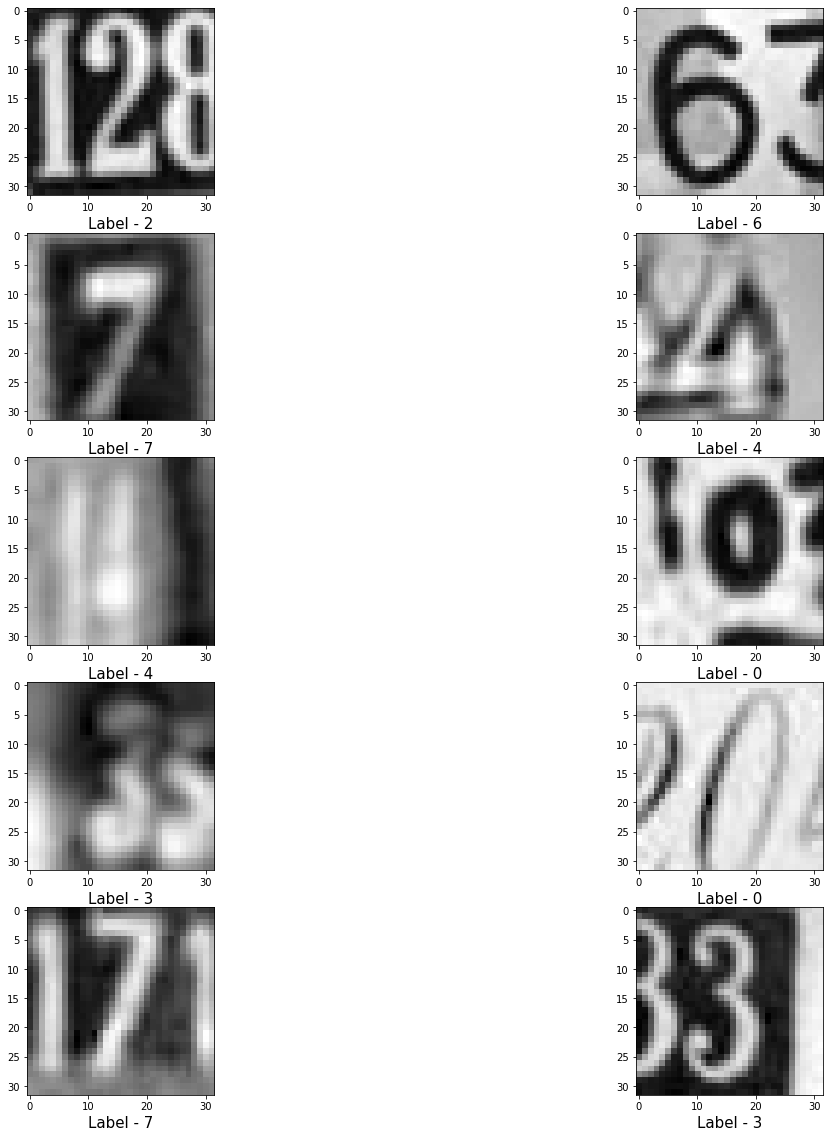

In [9]:
# Looking at gray scale version of images
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(X_train[i], cmap="gray")
    #plt.axis('off')
    plt.xlabel(f'Label - {y_train[i]}', fontsize = 15)
    #plt.tight_layout()
#plt.show()

### Reshaping Features for input data to NN model

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
print('Dimensions of Train Set after re-shaping are {}'.format(X_train.shape))
print('Dimensions of Validation Set after re-shaping are {}'.format(X_val.shape))
print('Dimensions of Test Set after re-shaping are {}'.format(X_test.shape))

Dimensions of Train Set after re-shaping are (42000, 1024)
Dimensions of Validation Set after re-shaping are (60000, 1024)
Dimensions of Test Set after re-shaping are (18000, 1024)


### Normalizing Features

In [11]:
print('Before')
print(X_train.max())
print(X_train.min())

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print('After')
print(X_train.max())
print(X_train.min())

Before
254.9745
0.0
After
0.9999
0.0


### Converting the labels to one hot vectors

In [12]:
# Before and After sanity check
print(y_train[10])
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print(y_train[10])

1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
#sgd1 = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)
#sgd2 = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9)
#adam1 = optimizers.Adam(lr=0.01, decay=1e-6)
#adam2 = optimizers.Adam(lr=0.001, decay=1e-6)

### First Basic Neural Networks Model

In [13]:
# We use adam optimizer throught out the notebook, initializing the kernel with he initializer at each hidden network and L2 regularization at output.
# Learning rate and Lambda are the hyperparameters here that we can tweak 

def basicFCNN(lr, Lambda, activation, k_initial, verb=True):
    ## hyperparameters
    #epochs = iterations
    learning_rate = lr
        
    model = Sequential()
    model.add(Dense(512, input_shape = (X_train.shape[1], ), kernel_initializer=k_initial, name='Input'))
    model.add(Activation(activation))
    model.add(Dense(256, kernel_initializer=k_initial, name='Hidden_Layer_1'))
    model.add(Activation(activation))
    model.add(Dense(128, kernel_initializer=k_initial, name='Hidden_Layer_2'))
    model.add(Activation(activation))
    model.add(Dense(64, kernel_initializer=k_initial, name='Hidden_Layer_3'))
    model.add(Activation(activation))
    model.add(Dense(32, kernel_initializer=k_initial, name='Hidden_Layer_4'))
    model.add(Activation(activation))
    model.add(Dense(10, kernel_regularizer=regularizers.l2(Lambda), name='Output'))
    model.add(Activation('softmax'))
    
    #opt = adam1
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate, decay=1e-6), metrics=['accuracy'])
    model.summary()
    
    #model.fit(X_train, y_train, validation_data=(X_val[:14000], y_val[:14000]), 
    #                epochs=100, batch_size=1000, verbose= 1)
    return model

Now we are gonna build the model slowly, performing sanity checks along the way by optimizing the hyperparameters as much as we can.

In [14]:
# LR - 0.00001, Lambda - 0
model1 = basicFCNN(0.00001, 0, 'relu', 'he_normal', verb=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 64)                8

In [15]:
model1.fit(X_train, y_train, validation_data=(X_val[:14000], y_val[:14000]), 
                    epochs=1, batch_size=500, verbose= 1)

84/84 [==============================] - 1s 10ms/step - loss: 2.3231 - accuracy: 0.1077 - val_loss: 2.2704 - val_accuracy: 0.1648


There are 10 output classes and the model is correctly predicting 1 up on 10 times (1/10 = 0.1% approx) as it is untrained and having 0.00001 learning rate

In [ ]:
# LR - 0.00001, Lambda - 1e3
model2 = basicFCNN(0.00001, 1e3, 'relu', 'he_normal', verb=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 64)               

In [ ]:
model2.fit(X_train, y_train, validation_data=(X_val[:14000], y_val[:14000]), 
                    epochs=1, batch_size=500, verbose= 1)

84/84 [==============================] - 1s 6ms/step - loss: 13189.6396 - accuracy: 0.1109 - val_loss: 13142.5840 - val_accuracy: 0.1258


Loss shot up ! That is good

In [17]:
# LR - 0.001, Lambda - 0
model3 = basicFCNN(0.001, 0, 'relu', 'he_normal', verb=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
activation_12 (Activation)   (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_14 (Activation)   (None, 128)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 64)               

Here we are going to overfit the model by taking a subset of the dataset to ensure that our model architecture is good

In [18]:
model3.fit(X_train[:20], y_train[:20], validation_data=(X_val[:7], y_val[:7]), 
                    epochs=500, batch_size=500, verbose= 1)

Epoch 1/500
1/1 [==============================] - 0s 171ms/step - loss: 2.6287 - accuracy: 0.0000e+00 - val_loss: 2.5087 - val_accuracy: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 0s 39ms/step - loss: 2.3465 - accuracy: 0.1500 - val_loss: 2.1171 - val_accuracy: 0.0000e+00
Epoch 3/500
1/1 [==============================] - 0s 38ms/step - loss: 2.0588 - accuracy: 0.1500 - val_loss: 1.8243 - val_accuracy: 0.0000e+00
Epoch 4/500
1/1 [==============================] - 0s 45ms/step - loss: 1.9498 - accuracy: 0.1500 - val_loss: 1.5726 - val_accuracy: 0.0000e+00
Epoch 5/500
1/1 [==============================] - 0s 36ms/step - loss: 1.8697 - accuracy: 0.1500 - val_loss: 1.4419 - val_accuracy: 0.7143
Epoch 6/500
1/1 [==============================] - 0s 40ms/step - loss: 1.8433 - accuracy: 0.3500 - val_loss: 1.4865 - val_accuracy: 0.1429
Epoch 7/500
1/1 [==============================] - 0s 38ms/step - loss: 1.8252 - accuracy: 0.2500 - val_loss: 1.4865 - val_accuracy: 0.8571

### Sanity Checks Passed. Time to fine tune the Hyperparameters !

In [19]:
# LR - 1e-7, Lambda - 1e-7
model4 = basicFCNN(1e-7, 1e-7, 'relu', 'he_normal', verb=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_20 (Activation)   (None, 128)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 64)               

In [20]:
model4.fit(X_train, y_train, validation_data=(X_val[:14000], y_val[:14000]), 
                    epochs=20, batch_size=500, verbose= 1)

Epoch 1/20
84/84 [==============================] - 1s 10ms/step - loss: 2.3466 - accuracy: 0.1025 - val_loss: 2.3893 - val_accuracy: 0.0190
Epoch 2/20
84/84 [==============================] - 1s 8ms/step - loss: 2.3434 - accuracy: 0.1012 - val_loss: 2.3867 - val_accuracy: 0.0150
Epoch 3/20
84/84 [==============================] - 1s 8ms/step - loss: 2.3404 - accuracy: 0.1009 - val_loss: 2.3843 - val_accuracy: 0.0129
Epoch 4/20
84/84 [==============================] - 1s 8ms/step - loss: 2.3377 - accuracy: 0.1005 - val_loss: 2.3820 - val_accuracy: 0.0109
Epoch 5/20
84/84 [==============================] - 1s 8ms/step - loss: 2.3351 - accuracy: 0.0995 - val_loss: 2.3800 - val_accuracy: 0.0090
Epoch 6/20
84/84 [==============================] - 1s 8ms/step - loss: 2.3328 - accuracy: 0.0988 - val_loss: 2.3778 - val_accuracy: 0.0083
Epoch 7/20
84/84 [==============================] - 1s 8ms/step - loss: 2.3307 - accuracy: 0.0985 - val_loss: 2.3759 - val_accuracy: 0.0083
Epoch 8/20
84/84 [=

Lets increase the learning rate as it is too low.
Lets increase LR.

In [22]:
# LR - 1e4, Lambda - 1e-7
model5 = basicFCNN(1e4, 1e-7, 'relu', 'he_normal', verb=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
activation_30 (Activation)   (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_31 (Activation)   (None, 256)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_32 (Activation)   (None, 128)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 64)               

In [23]:
model5.fit(X_train, y_train, validation_data=(X_val[:14000], y_val[:14000]), 
                    epochs=20, batch_size=500, verbose= 1)

Epoch 1/20
84/84 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.0995 - val_loss: nan - val_accuracy: 0.2857
Epoch 2/20
84/84 [==============================] - 1s 8ms/step - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.2857
Epoch 3/20
84/84 [==============================] - 1s 8ms/step - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.2857
Epoch 4/20
84/84 [==============================] - 1s 8ms/step - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.2857
Epoch 5/20
84/84 [==============================] - 1s 8ms/step - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.2857
Epoch 6/20
84/84 [==============================] - 1s 8ms/step - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.2857
Epoch 7/20
84/84 [==============================] - 1s 8ms/step - loss: nan - accuracy: 0.0997 - val_loss: nan - val_accuracy: 0.2857
Epoch 8/20
84/84 [==============================] - 1s 8ms/st

### Loss exploding. Learning rate is too high.
### Cost is very high. Always means high learning rate.

### Now lets do cross validation to optimize hyperparameters by taking a rough range of values

We use the first 14000 images of validation set to validate and full test set to evaluate model.

In [24]:
def basicHPCheckFCNN(iterations ,lr, Lambda, activation, k_initial, verb=True):
    ## hyperparameters
    epochs = iterations
    learning_rate = lr
        
    model = Sequential()
    model.add(Dense(512, input_shape = (X_train.shape[1], ), kernel_initializer=k_initial, name='Input'))
    model.add(Activation(activation))
    model.add(Dense(256, kernel_initializer=k_initial, name='Hidden_Layer_1'))
    model.add(Activation(activation))
    model.add(Dense(128, kernel_initializer=k_initial, name='Hidden_Layer_2'))
    model.add(Activation(activation))
    model.add(Dense(64, kernel_initializer=k_initial, name='Hidden_Layer_3'))
    model.add(Activation(activation))
    model.add(Dense(32, kernel_initializer=k_initial, name='Hidden_Layer_4'))
    model.add(Activation(activation))
    model.add(Dense(10, kernel_initializer=k_initial, kernel_regularizer=regularizers.l2(Lambda), name='Output'))
    model.add(Activation('softmax'))
    
    #opt = adam1
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
    model.summary()
    
    # Fit the model
    model.fit(X_train, y_train, validation_data=(X_val[:14000], y_val[:14000]),
              epochs=iterations, batch_size=500, verbose= 1)
    score = model.evaluate(X_test, y_test, verbose=0)
    
    return score

In [25]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-7.0, 3.0))
    Lambda = math.pow(10, np.random.uniform(-7,-2))
    best_acc = basicHPCheckFCNN(100, lr, Lambda,'relu', 'he_normal', False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
activation_36 (Activation)   (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_37 (Activation)   (None, 256)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_38 (Activation)   (None, 128)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 64)               

Lets take the below mentioned range now based on above results intuition.

In [26]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-5.0, -3.0))
    Lambda = math.pow(10, np.random.uniform(-5,-3))
    best_acc = basicHPCheckFCNN(100, lr, Lambda,'relu', 'he_normal', False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
activation_90 (Activation)   (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_91 (Activation)   (None, 256)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_92 (Activation)   (None, 128)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 64)              

Increasing the epochs to 200 from 100

In [27]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-5.0, -3.0))
    Lambda = math.pow(10, np.random.uniform(-5,-3))
    best_acc = basicHPCheckFCNN(200, lr, Lambda,'relu', 'he_normal', False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
activation_144 (Activation)  (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_145 (Activation)  (None, 256)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_146 (Activation)  (None, 128)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 64)              

In [28]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-5.0, -4.0))
    Lambda = math.pow(10, np.random.uniform(-5.0,-4.0))
    best_acc = basicHPCheckFCNN(100, lr, Lambda,'relu', 'he_normal', False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
activation_198 (Activation)  (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_199 (Activation)  (None, 256)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_200 (Activation)  (None, 128)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 64)              

In [30]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-4.25, -4.2))
    Lambda = math.pow(10, np.random.uniform(-4.25,-4.2))
    best_acc = basicHPCheckFCNN(200, lr, Lambda,'relu', 'he_normal', False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
activation_258 (Activation)  (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
activation_259 (Activation)  (None, 256)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
activation_260 (Activation)  (None, 128)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 64)              

#### After some lot of testing, i found the learning rate around 6.14e-5 is good and a lambda of around 5.843-5 is good. For me optimal learning rate i found is 6.137809361954345e-05 and optimal Lambda is 5.8364246649734e-05 with a model which generalizes very well , where training and test accuracy is almost similar and should not be more than 7% apart.

## Adding Batch Normalization & Dropouts now

In [ ]:


def basicDeepNN1(iterations, lr, Lambda, activation, k_initial, verb=True):
    ## hyperparameters
    epochs = iterations
    learning_rate = lr
        
    model = Sequential()
    model.add(Dense(512, input_shape = (X_train.shape[1], ), kernel_initializer=k_initial, name='Input'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(Dense(256, kernel_initializer=k_initial, name='Hidden_Layer_1'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(Dense(128, kernel_initializer=k_initial, name='Hidden_Layer_2'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(Dense(64, kernel_initializer=k_initial, name='Hidden_Layer_3'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(Dense(32, kernel_initializer=k_initial, name='Hidden_Layer_4'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(Dense(10, kernel_initializer=k_initial ,kernel_regularizer=regularizers.l2(Lambda), name='Output'))
    model.add(Activation('softmax'))
    
    #opt = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
    model.summary()
    # Fit the model
    model.fit(X_train, y_train, validation_data=(X_val[:14000], y_val[:14000]),
              epochs=iterations, batch_size=500, verbose= 1)
    score = model.evaluate(X_test, y_test, verbose=0)
    
    return score

In [32]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-4.22, -4.21))
    Lambda = math.pow(10, np.random.uniform(-4.24, -4.23))
    best_acc = basicDeepNN1(200, lr, Lambda,'relu', 'he_normal', False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation_312 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_313 (Activation)  (None, 256)             

### Model accuracy for test data is slightly better with an increase of 3-4% after adding Batch Normalization

In [ ]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-5.0, -4.0))
    Lambda = math.pow(10, np.random.uniform(-5,-4))
    best_acc = basicDeepNN2(150, lr, Lambda,'relu', 'he_normal', False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization_120 (Bat (None, 512)               2048      
_________________________________________________________________
activation_144 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_120 (Dropout)        (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_121 (Bat (None, 256)               1024      
_________________________________________________________________
activation_145 (Activation)  (None, 256)             

In [33]:
# Removing Dropout at last two layers
def basicDeepNN2(iterations, lr, Lambda, activation, k_initial, verb=True):
    ## hyperparameters
    epochs = iterations
    learning_rate = lr
        
    model = Sequential()
    model.add(Dense(512, input_shape = (X_train.shape[1], ), kernel_initializer=k_initial, name='Input'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(Dense(256, kernel_initializer=k_initial, name='Hidden_Layer_1'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(Dense(128, kernel_initializer=k_initial, name='Hidden_Layer_2'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(Dense(64, kernel_initializer=k_initial, name='Hidden_Layer_3'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    #model.add(Dropout(0.2))
    model.add(Dense(32, kernel_initializer=k_initial, name='Hidden_Layer_4'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    #model.add(Dropout(0.2))
    model.add(Dense(10, kernel_initializer=k_initial ,kernel_regularizer=regularizers.l2(Lambda), name='Output'))
    model.add(Activation('softmax'))
    
    #opt = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
    model.summary()
    # Fit the model
    model.fit(X_train, y_train, validation_data=(X_val[:14000], y_val[:14000]),
              epochs=iterations, batch_size=500, verbose= 1)
    score = model.evaluate(X_test, y_test, verbose=0)
    
    return score

In [34]:
import math
for k in range(1,11):
    lr = math.pow(10, np.random.uniform(-4.22, -4.21))
    Lambda = math.pow(10, np.random.uniform(-4.24, -4.23))
    best_acc = basicDeepNN2(200, lr, Lambda,'relu', 'he_normal', False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization_45 (Batc (None, 512)               2048      
_________________________________________________________________
activation_366 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
activation_367 (Activation)  (None, 256)             

### Not much difference with dropout left out in last two hidden layers

## Adding Leaky ReLU as activation inplace of ReLU

In [35]:
def basicDeepNN3(iterations, lr, Lambda, activation, k_initial, al, verb=True):
    ## hyperparameters
    epochs = iterations
    learning_rate = lr
        
    model = Sequential()
    model.add(Dense(512, input_shape = (X_train.shape[1], ), kernel_initializer=k_initial, name='Input'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(0.2))
    model.add(Dense(256, kernel_initializer=k_initial, name='Hidden_Layer_1'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(0.2))
    model.add(Dense(128, kernel_initializer=k_initial, name='Hidden_Layer_2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(0.2))
    model.add(Dense(64, kernel_initializer=k_initial, name='Hidden_Layer_3'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(0.2))
    model.add(Dense(32, kernel_initializer=k_initial, name='Hidden_Layer_4'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(0.2))
    model.add(Dense(10, kernel_initializer=k_initial ,kernel_regularizer=regularizers.l2(Lambda), name='Output'))
    model.add(Activation('softmax'))
    
    #opt = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
    model.summary()
    # Fit the model
    train_model = model.fit(X_train, y_train, validation_data=(X_val[:14000], y_val[:14000]),
              epochs=iterations, batch_size=500, verbose= 1)
    test = model.evaluate(X_test, y_test, verbose=0)
    
    return (train_model , test)

In [36]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-4.22, -4.21))
    Lambda = math.pow(10, np.random.uniform(-4.24, -4.23))
    train , score = basicDeepNN3(200, lr, Lambda,'relu', 'he_normal', 0.01, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, score, lr, Lambda))

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization_95 (Batc (None, 512)               2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_96 (Batc (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)             

## It looks like we have found our best parameters till now with the learning rate as 6.0379383617791225e-05 and lambda as 5.814141068427433e-05 with alpha as 0.01 in LeakyReLU activation 

In [39]:
train, test = basicDeepNN3(200, 6.0379383617791225e-05, 5.814141068427433e-05,'relu', 'he_normal',0.01, False)


Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization_145 (Bat (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_125 (Dropout)        (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_146 (Bat (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 256)             

In [40]:
print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(1, 100, test, 6.0379383617791225e-05, 5.814141068427433e-05))

Try 1/100: Best_val_acc: [0.5196089744567871, 0.8460000157356262], lr: 6.0379383617791225e-05, Lambda: 5.814141068427433e-05



In [45]:
train, score = basicDeepNN3(200, 6.027611403498033e-05, 5.842026004053601e-05,'relu', 'he_normal',0.01, False)


Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization_160 (Bat (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_140 (Dropout)        (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_161 (Bat (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 256)             

In [46]:
print("Best_test_acc: {0}, lr: {1}, Lambda: {2}\n".format(score, 6.027611403498033e-05, 5.842026004053601e-05))

Best_test_acc: [0.4821937382221222, 0.8612222075462341], lr: 6.027611403498033e-05, Lambda: 5.842026004053601e-05



In [43]:
train, score = basicDeepNN3(200, 6.137809361954345e-05, 5.8364246649734e-05,'relu', 'he_normal',0.01, False)


Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization_155 (Bat (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_135 (Dropout)        (None, 512)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_156 (Bat (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 256)             

In [44]:
print("Best_test_acc: {0}, lr: {1}, Lambda: {2}\n".format( score, 6.027611403498033e-05, 5.8364246649734e-05))

Best_test_acc: [0.5280612111091614, 0.8437222242355347], lr: 6.137809361954345e-05, Lambda: 5.8364246649734e-05



### It looks like we had to take a detour to find our best parameters till now with the learning rate as 6.027611403498033e-05 and lambda as 5.842026004053601e-05 with alpha as 0.01 in LeakyReLU activation 

### It is highly likely that we have fallen into a local minima because of which we cannot get into the prestigious 90%+ accuracy score.

In [47]:
# Save the model and weights
train.model.save('DL3_model.h5')
train.model.save_weights('DL3_weights.h5')

In [48]:
train.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

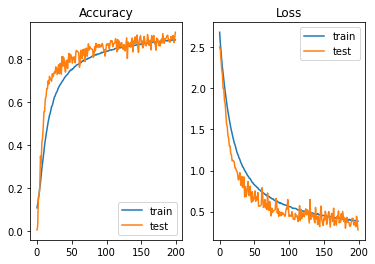

In [49]:
# Getting Accuracy and Loss plots
fig,ax = plt.subplots(1,2)
ax[0].set_title('Accuracy')
ax[0].plot(train.history['accuracy'],label='train')
ax[0].plot(train.history['val_accuracy'],label='test')
ax[0].legend()

ax[1].set_title('Loss')
ax[1].plot(train.history['loss'],label='train')
ax[1].plot(train.history['val_loss'],label='test')
ax[1].legend()

## Predicting Images

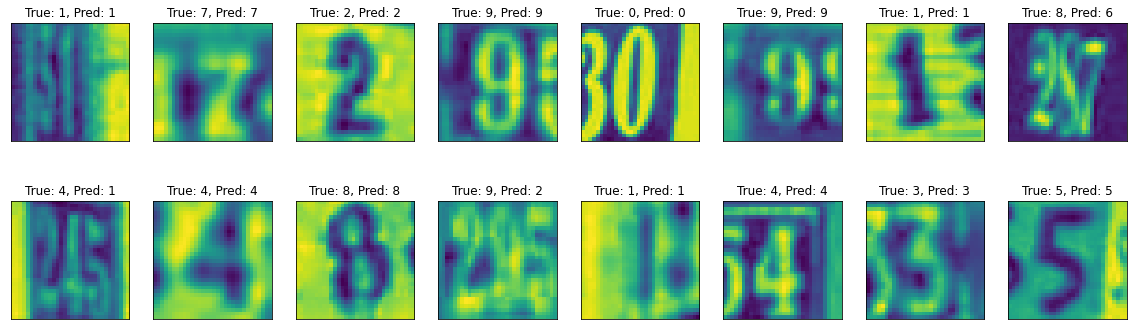

In [50]:
plot_images(Xtest, ytest, 2, 8, train.model.predict(X_test))

## As seen above we are predicting 13 out of 16 images correctly. The ones where we made wrong prediction, we have three whole digits in the image. This might be interferring with the prediction. The correctly predicted images have the true label at the center of the image and the other interferring digits partially present in image but not fully.

## Generating the Classification Report

In [51]:
def classificationReport(y_true,y_pred):
    target_names = [f"Class {i}" for i in range(10) ]
    print(classification_report(y_true,y_pred,target_names=target_names))

In [52]:
preds = np.argmax(train.model.predict(X_test), axis = -1)

In [53]:
preds

array([1, 7, 2, ..., 7, 9, 2])

In [54]:
pred = to_categorical(preds,num_classes=10)
classificationReport(y_test,pred)
multilabel_confusion_matrix(y_test,pred)

              precision    recall  f1-score   support

     Class 0       0.84      0.91      0.88      1814
     Class 1       0.79      0.91      0.85      1828
     Class 2       0.91      0.87      0.89      1803
     Class 3       0.76      0.86      0.81      1719
     Class 4       0.94      0.86      0.90      1812
     Class 5       0.84      0.86      0.85      1768
     Class 6       0.93      0.80      0.86      1832
     Class 7       0.88      0.91      0.89      1808
     Class 8       0.87      0.79      0.83      1812
     Class 9       0.88      0.84      0.86      1804

   micro avg       0.86      0.86      0.86     18000
   macro avg       0.87      0.86      0.86     18000
weighted avg       0.87      0.86      0.86     18000
 samples avg       0.86      0.86      0.86     18000



array([[[15879,   307],
        [  156,  1658]],

       [[15737,   435],
        [  165,  1663]],

       [[16046,   151],
        [  239,  1564]],

       [[15825,   456],
        [  248,  1471]],

       [[16095,    93],
        [  246,  1566]],

       [[15935,   297],
        [  245,  1523]],

       [[16055,   113],
        [  366,  1466]],

       [[15959,   233],
        [  165,  1643]],

       [[15982,   206],
        [  372,  1440]],

       [[15989,   207],
        [  296,  1508]]])

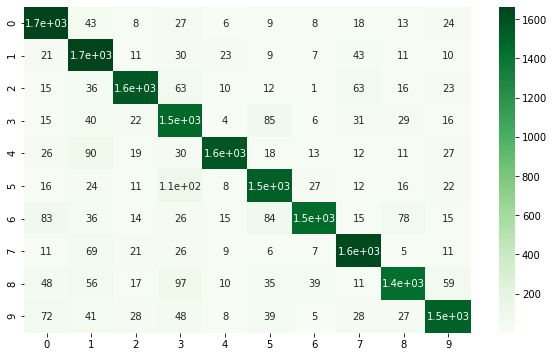

In [55]:
cm = confusion_matrix(y_test.argmax(axis=1),pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index=[i for i in '0123456789'], columns= [i for i in '0123456789'])
plt.figure(figsize=(10,6))
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
sns.heatmap(cm_df,annot=True,cmap='Greens')

## So the F1 score lies at 0.86 for the test data. The worst F1 score lies at 0.81 for the digit 3 . The best F1 score lies at 0.90 for the digit 4.